<a href="https://colab.research.google.com/github/KringeKrimson/Pytorch-Basics/blob/main/Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import all the required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms #datasets already has MINST in it
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
# to make sure that matplotlib graphs will be displayed inline in the notebook


#Convert to tensor

In [2]:
transform = transforms.ToTensor()

#Prepare/Download Train data

In [3]:
train_data = datasets.MNIST(root='Simple_CNN', train=True, download=True, transform=transform)
                            #directory to save, Determines whether to load traning or testing set T: traning F: testing, download in local directory, transform(specificed by the user)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15993223.24it/s]


Extracting Simple_CNN/MNIST/raw/train-images-idx3-ubyte.gz to Simple_CNN/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1767037.09it/s]


Extracting Simple_CNN/MNIST/raw/train-labels-idx1-ubyte.gz to Simple_CNN/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7833357.76it/s]


Extracting Simple_CNN/MNIST/raw/t10k-images-idx3-ubyte.gz to Simple_CNN/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2945350.77it/s]

Extracting Simple_CNN/MNIST/raw/t10k-labels-idx1-ubyte.gz to Simple_CNN/MNIST/raw



#Test data

In [4]:
test_data = datasets.MNIST(root='Simple_CNN', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Simple_CNN
    Split: Test
    StandardTransform
Transform: ToTensor()

#Create Small batch size

In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Defining Convolutional layer

In [10]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,stride = 1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,stride = 1)

#Grab 1 MNIST record/image

In [14]:
for i, (X_train, y_train) in enumerate(train_data):
  print(f'Shape: {X_train.shape}')
  break

Shape: torch.Size([1, 28, 28])


#Rehshaping x to tensor

In [13]:
x = X_train.view(1,1,28,28)

#Perform first convolution

In [15]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

#Perform maxpool

In [16]:
x = F.max_pool2d(x, kernel_size=2, stride =2)
x.shape

torch.Size([1, 6, 13, 13])

# 2nd Convolution layer

In [17]:
x = F.relu(conv2(x))
x.shape


torch.Size([1, 16, 11, 11])

# 2nd Maxpool


In [18]:
x = F.max_pool2d(x,kernel_size=2,stride=2)
x.shape

torch.Size([1, 16, 5, 5])

# Defining the Model
Now the actual proper implementation


In [23]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    #defining convolutional layer (already done above but now implementing in class)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,stride = 1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,stride = 1)
    #defining fully connected layer
    self.fc1 = nn.Linear(5*5*16,120)    #(input dimension, output dimension/no. neurons)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10) #output layer

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,kernel_size=2,stride=2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,kernel_size=2,stride=2)

    #Flatten the data or flatten layer in tf
    X = X.view(-1,16*5*5) #you can calculate the dimension from the outpute shape from the last maxPool

    #Fully connected layer
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)





#Create an instance of the model

In [24]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#Loss function and Optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Train and Test

In [33]:
import time
start_time = time.time()
# variables to track things
epoch = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
# training epoch
for i in range(epoch):
  trn_corr = 0
  tst_corr = 0
  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start batches from 1
    y_pred = model(X_train) #get the predicted values from our CNN model
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred.data,1)[1] # torch.max(input, dim, keepdim=False, *, out=None)
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr
    # update parameters
    optimizer.zero_grad() #reset the gradient to zero cuz not RNN
    loss.backward()
    optimizer.step()
    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  # append the losses to keep track through list
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Trainking took:{total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 2.300760507583618
Epoch: 0 Batch: 1200 Loss: 2.3172507286071777
Epoch: 0 Batch: 1800 Loss: 2.3159635066986084
Epoch: 0 Batch: 2400 Loss: 2.3244192600250244
Epoch: 0 Batch: 3000 Loss: 2.279261589050293
Epoch: 0 Batch: 3600 Loss: 2.309140205383301
Epoch: 0 Batch: 4200 Loss: 2.3167471885681152
Epoch: 0 Batch: 4800 Loss: 2.329899311065674
Epoch: 0 Batch: 5400 Loss: 2.289776086807251
Epoch: 0 Batch: 6000 Loss: 2.3246476650238037
Epoch: 1 Batch: 600 Loss: 2.2748961448669434
Epoch: 1 Batch: 1200 Loss: 2.291625738143921
Epoch: 1 Batch: 1800 Loss: 2.315514087677002
Epoch: 1 Batch: 2400 Loss: 2.285210371017456
Epoch: 1 Batch: 3000 Loss: 2.3239006996154785
Epoch: 1 Batch: 3600 Loss: 2.2892229557037354
Epoch: 1 Batch: 4200 Loss: 2.287318706512451
Epoch: 1 Batch: 4800 Loss: 2.3528361320495605
Epoch: 1 Batch: 5400 Loss: 2.3181633949279785
Epoch: 1 Batch: 6000 Loss: 2.3091654777526855
Epoch: 2 Batch: 600 Loss: 2.3023416996002197
Epoch: 2 Batch: 1200 Loss: 2.3351569175720215


#Graphing the loss

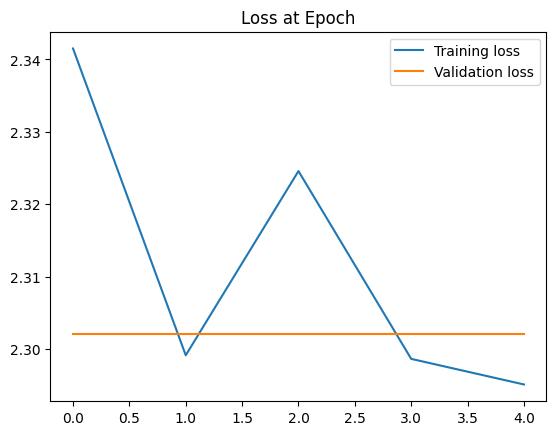

In [26]:
train_losses = [tl.item() for tl in train_losses] # convert tensor to python list
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label ="Validation loss")
plt.title("Loss at Epoch")
plt.legend()

#Graph Accuracy

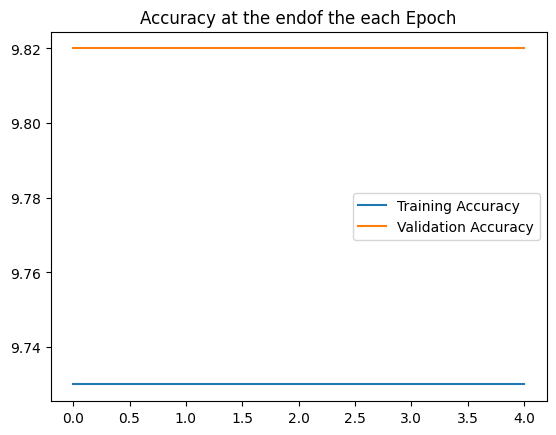

In [28]:
plt.plot([t/600 for t in train_correct], label ="Training Accuracy")
plt.plot([t/100 for t in test_correct], label= "Validation Accuracy")
plt.title("Accuracy at the endof the each Epoch")
plt.legend()

#Accuracy

In [32]:
test_load_everything = DataLoader(test_data, batch_size = len(test_data), shuffle=False) #load everything
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct+= (predicted == y_test).sum()

correct.item()/len(test_data)


0.0982

#Testing an actual image

In [34]:
test_data[4169]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

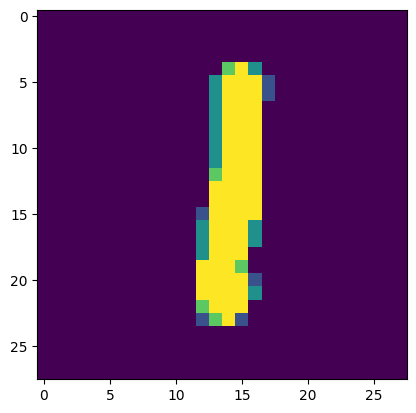

In [36]:
# Reshape it
test_data[4169][0].reshape(28,28)
# show it using pyplot
plt.imshow(test_data[4169][0].reshape(28,28))

In [40]:
#pass the image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4169][0].view(1,1,28,28)) # batch size of 1, 1 color channel and 28x28 image
#print the predicted
print(f'Predicted: {torch.argmax(new_prediction)}')

Predicted: 4
